In [2]:
#check q values
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm # Color maps
from IPython import display

from Environment import Environment, MRP, MDP 
import utils as u

sns.set_theme(font_scale = 0.7)
sns.set_style()

In [3]:
#Initialize
width, height = 5, 5 #Gridworld 
obstacle_states = [11,12,13] #Add obstacle states (existing states, however not or less accessible from other states)

In [15]:
#set-up environment
env = Environment(width, height)
env.add_forbidden_states([1,6,11,21,22,23,24,13,14,2,3,4])
env.add_absorbing_states([19])
env.P[9] = u.one_hot(19, env.nstates) #transition from goal state to absorbing state

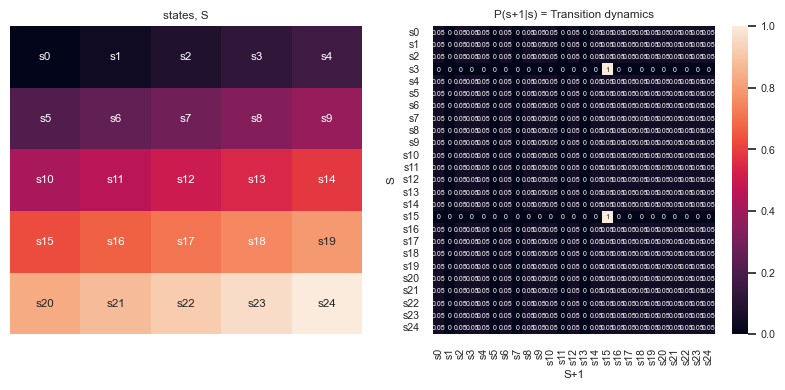

In [16]:
# visualise environment
fig, ax = plt.subplots(1, 2, figsize = (10,4))
plt.sca(ax[0])
plt.title('states, S')
env.plot_grid() 
plt.sca(ax[1])
env.plot_dynamics() 
plt.show()

In [22]:
# Markov Process (S, P)
n = 5 #number of events
start_state = 0

env.markov_chain(n = n, start_state = start_state)

array(['s0', 's19', 's21', 's10', 's21'], dtype='<U3')

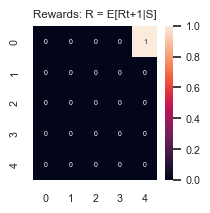

In [23]:
# Markov Reward Process (S, P, R, gamma)
goal_state = [4]
R = 1 #reward when reaching goal
gamma = 0.9 #discount factor
MRP_env = MRP(width = width, height = height, gamma = gamma) #create environment
penalty = 0 #can add penalty, be aware of reward shaping
MRP_env.set_rewards(goal_state, goal_reward = R, penalty_steps = penalty)

# Visualise rewards
plt.figure(figsize = (2,2))
MRP_env.plot_rewards()
plt.show()

In [34]:
#MRP
n = 100
start_state = 15

Gt = MRP_env.markov_reward_process(start_state, n = 100)
print(f'Gt (Return): {Gt}')

Gt (Return): 0.0


In [36]:
#value function: v(s) = E[Gt|St = s]
episodes = 100
state_value = MRP_env.state_value_function(start_state = start_state, episodes = episodes, n = n)
print(f'E[Gt|St = {start_state}]: {state_value}')

E[Gt|St = 15]: 0.4504415693430608


v(s): 1.3615271165028662


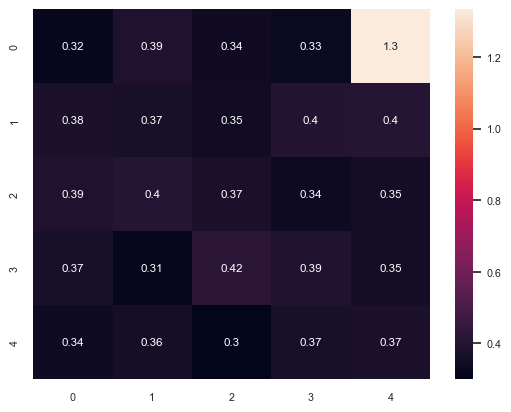

In [37]:
# Check bellman expectation tree search
# Bellmann expectation MRP's: v(s) = E[Rt+1 + gamma * v(s') |St = s]
# get all values
state_values = np.zeros(MRP_env.nstates)
for i in range(MRP_env.nstates): #loop over all starting_states
    state_value = MRP_env.state_value_function(start_state = i, episodes = episodes, n = n)
    state_values[i] = state_value
MRP_env.heatmap(state_values)

# v(s) = Rs + gamma * sum_over_successor_states(Pss'v(s')): 
state = 4
immediate_reward = MRP_env.reward_function(state) #Rs
gamma = gamma
p = MRP_env.P[state] #Pss'
v_successors = state_values #v(s')

#check
v_state = immediate_reward + gamma * np.sum(p * v_successors)
print(f'v(s): {v_state}')

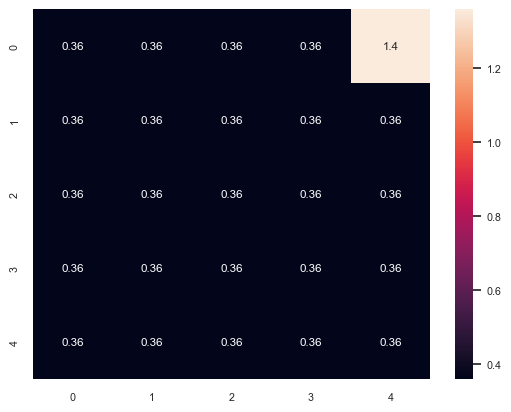

In [38]:
# Solving Bellmann expectation in matrix form
values = MRP_env.bellmann_expectation_matrix()
MRP_env.heatmap(values)

## MDP

In [79]:
#Fully observable MDP -> redo reward to Rsa
start_state = 0
goal_state = 9
gamma = 0.9
env = MDP(width = width, height = height, gamma = gamma)
env.set_rewards(goal_state)


In [80]:
#3.1: p(s', r|s, a)
action = np.random.choice(env.agent.n_actions)
state = np.random.choice(env.nstates)

print(action, state)
env.P # #p(s', s)
env.P[0] #P(s'|s)
#sns.heatmap(env.get_transition_action(action)) #p(s', s|a)
#plt.show()
a, b, c, transition_probs = env.dynamics_environment(state = state, action = action) #p(s',r|s,a), p(s'|s, a), (3,2)
next_state = np.random.choice(env.nstates, p = transition_probs)
print(next_state)
print(env.R) #r(s,a)


3 10
11
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]


In [81]:
#print(f'(3.2): {a[0]}') 
print(f'(3.3): {np.sum(a)}') 
print(f'(3.4): {np.sum(a, axis = 1)}')  #p(s'|s,a)
print(f'(3.5) {env.reward_function(state = 0, action = 1)}')#3.5 -> can not directly get it from a, since the values are inaccurate, if you look at the code, you'll see the successor states weighting the rewards and getting the dot product
print(f'3.6 {env.reward_function(state = state, action = action)}')# r(s, a, s')


(3.3): 1.0
(3.4): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(3.5) 0.0
3.6 0.0


In [82]:
#check dynamics
def markov_reward_process(env, start_state, n = 100):
    next_state = start_state
    terminate = False
    t = 0
    t_end = n # time horizon
    gamma = env.gamma

    #Bookkeeping
    env.agent.Gt = 0 #return
    trajectory = [env.states.get(start_state)] #keep track of location, just for visualisation, don't use
    fig = env.render(start_state, env.map)

    #Step through environment
    while (t != t_end-1):
        current_state = next_state #St
        #Agent receives reward and state
        action = env.agent.step(current_state) #Agent picks an action
        t+=1 #step
        reward = env.R[action][int(current_state)] #Rt+1
        dynamics = env.dynamics_environment(state = current_state, action = action)[3]

        next_state = np.random.choice(env.nstates, p = dynamics) #St+1
            

        #Bookkeeping
        fig = env.render(next_state, env.map)
        plt.close(fig)
        
        env.agent.Gt += (gamma ** (t-1) * reward)
        trajectory.append(f'{env.states.get(next_state)}')

    return env.agent.Gt, np.array(trajectory).T

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


<Axes: >

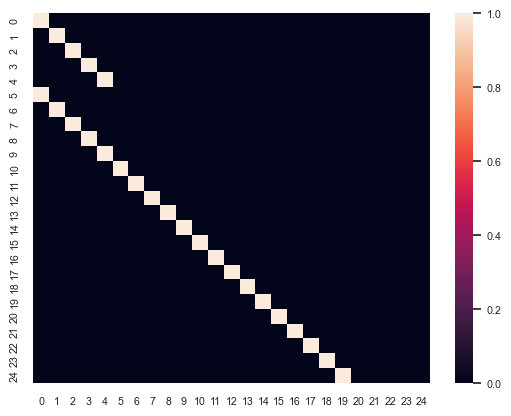

In [83]:
print(env.P[3][9])
sns.heatmap(env.P[0])

(0.0,
 array(['s0', 's0', 's1', 's2', 's7', 's12', 's11', 's16', 's15', 's10',
        's11', 's10', 's5', 's6', 's11', 's12', 's13', 's18', 's13', 's8',
        's7', 's12', 's7', 's6', 's5', 's6', 's1', 's0', 's0', 's0', 's0',
        's0', 's5', 's10', 's5', 's10', 's11', 's10', 's11', 's10', 's10',
        's5', 's10', 's15', 's16', 's17', 's22', 's21', 's21', 's16',
        's21', 's20', 's15', 's10', 's11', 's10', 's5', 's10', 's5', 's10',
        's5', 's0', 's1', 's1', 's6', 's7', 's6', 's11', 's12', 's13',
        's14', 's19', 's14', 's13', 's18', 's17', 's22', 's21', 's16',
        's21', 's20', 's20', 's21', 's20', 's15', 's10', 's11', 's6', 's7',
        's8', 's13', 's12', 's17', 's18', 's13', 's18', 's23', 's18',
        's23', 's24'], dtype='<U3'))

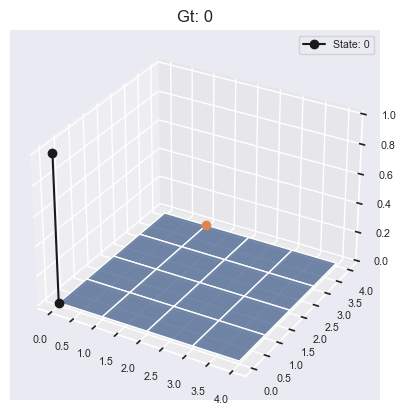

In [84]:
markov_reward_process(env = env, start_state= 0)


In [85]:
#policies (2)
print(env.transition_pi(state = 10))
print(env.reward_pi(state = 5))

[0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.25 0.25 0.   0.
 0.   0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
0.0


In [86]:
#value function, monte carlo
env.state_value_function(start_state = 0)

0.1520511651465424

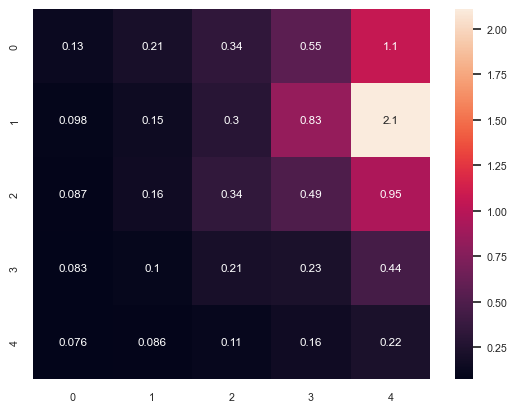

In [87]:
state_values = np.zeros(env.nstates)
for i in range(env.nstates): #loop over all starting_states
    state_value = env.state_value_function(start_state = i, episodes = 100, n = 100)
    state_values[i] = state_value
env.heatmap(state_values)

In [88]:
#action value function, monte carlo
env.q_value(start_state = 8, start_action = 3)

2.4404860832039352

In [89]:
env.state_action_value(start_state = 5, start_action = 3)

0.20121220816297075

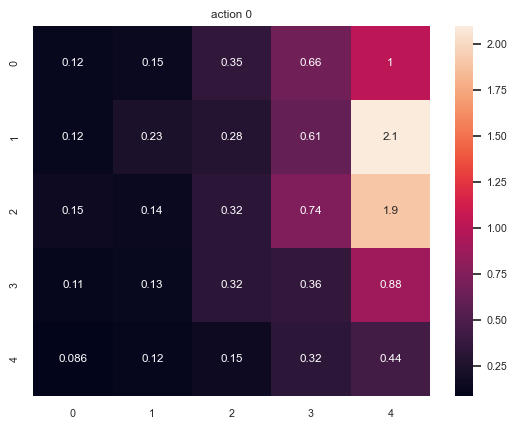

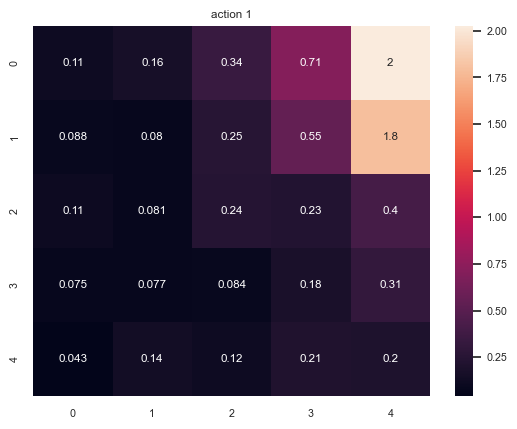

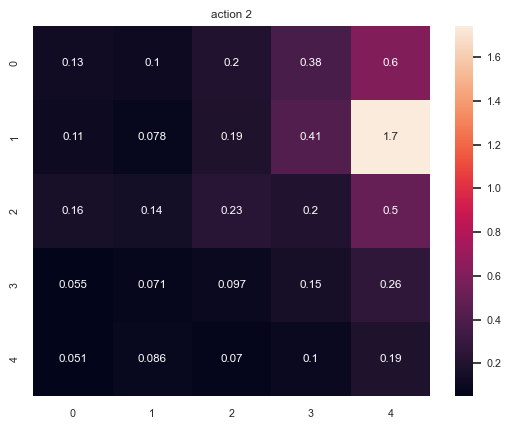

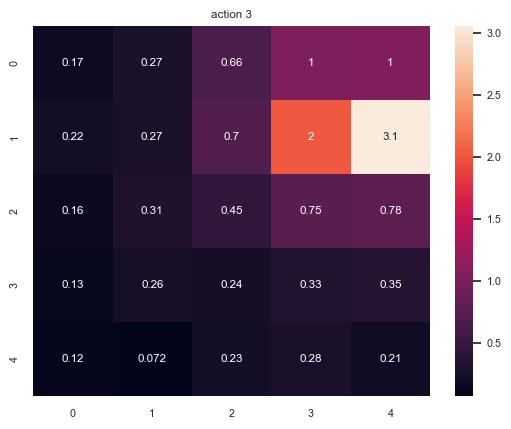

In [90]:
q_values = np.zeros((env.agent.n_actions, env.nstates))

for i in range(env.agent.n_actions): #loop actions
    for j in range(env.nstates): #loop states
        q_values[i][j] = env.state_action_value(start_state = j, start_action = i, episodes = 100, n = 100)
    env.heatmap(q_values[i])
    plt.title(f'action {i}')
    plt.show()

In [95]:
#Bellmann expectation, state-value
state = 8
pi = env.agent.policy[state] #pi(a|s)
r = env.R[:, state]
for i in env.forbidden_states:
    state_values[i] = 0
value = 0

for action in range(env.agent.n_actions):
    p = env.dynamics_environment(state = state, action = action)[3] #p(s' |s,a)
    value += pi[action] * np.dot(p, (r[action] + env.gamma * state_values)) #sum over actions
value

0.7765708231950863

In [96]:
#Bellmann expectation, state-action-value
state = 5
pi = env.agent.policy[state] #pi(a|s)
r = env.R[action][state]
action = 3
p = env.dynamics_environment(state = state, action = action)[3] #p(s' |s,a)
q_value = np.dot(p, (r + env.gamma * state_values)) #sum over actions
q_value

0.133153276100926

[0.   0.   0.   0.   0.25 0.   0.   0.   0.25 0.25 0.   0.   0.   0.
 0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]


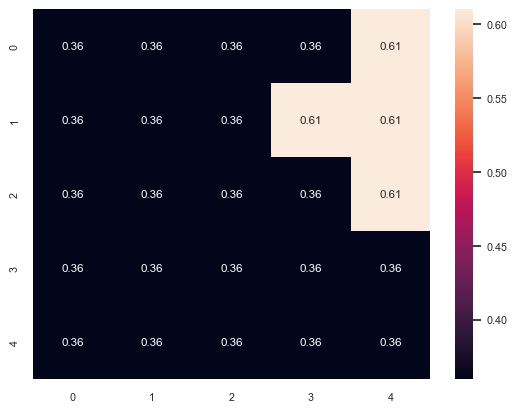

In [97]:
#bellman expectation matrix state-action, for optimality, use optimal policy, non-linear, thus no matrix equation possible 
R = np.zeros(env.nstates)
p = np.zeros(env.nstates) #could probably get this out of the other functions somewhere
for i in range(env.nstates):
    R[i] = env.reward_pi(state = i)
    p += env.transition_pi(state = i)
p = np.divide(p, env.nstates)
print(R)
gamma = env.gamma

# # R + gamma * (P@v) -> v = inv(I - gamma * Ppi) @ Rpi
state_values_matrix = np.linalg.inv((np.identity(env.nstates) - (gamma * p))) @ R
env.heatmap(state_values_matrix)


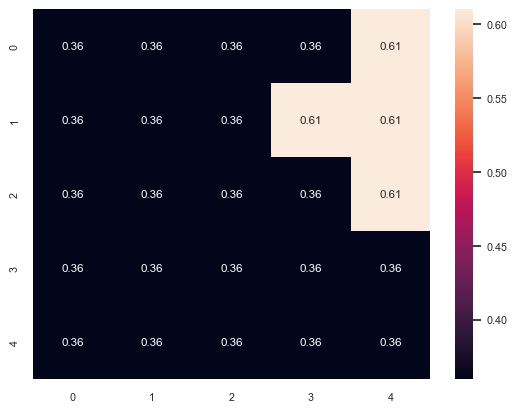

In [98]:
env.heatmap(env.bellmann_q_expectation_matrix()) 

In [101]:
# optimal policy -> not quite right
policy = env.agent.policy
policies = []
for state in range(env.nstates):
    best_action = np.argmax(q_values[:, state])
    policy[state] = u.one_hot(best_action, env.agent.n_actions)
    policies.append(env.agent.actions.get(np.argmax(policy[state]))[1])
print(env.fit_grid(np.array(policies)))

[['→' '→' '→' '→' '↓']
 ['→' '→' '→' '→' '→']
 ['←' '→' '→' '→' '↑']
 ['→' '→' '↑' '↑' '↑']
 ['→' '↓' '→' '↑' '↑']]
